# Full regional extraction
Here we will extract cells from a variable size continuous polygon.
This will be the first step in doing a full regionalising model.
> For simplicity we restrict the list to only one polygon

In [1]:
#Loading things as usual
#%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Ok, the approach will be this
1. Let $p=(x,y)$ in Mexico
2. Create a buffer size list (maybe exponential) not to big.
4. Generate a list of polygons according to this list.
5. Overlay with the mesh (lowest resolution)
6. Extract cells, or cell ids.


In [2]:
from django.contrib.gis.geos import Point, Polygon
#coord = -99.76
#coord = 17.55
#xcoord = -98.219
#ycoord = 19.05
xcoord = -97.237
ycoord = 19.482
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,2,10)
polys = map(lambda r : p.buffer(r),radii)


In [3]:
## Intersect the polygons with the cells to obtain the targets

In [4]:
from mesh.models import initMesh

In [5]:
mexmesh = initMesh(11)

DEBUG Changed MESH TABLE SPACE


In [6]:
## restrict the polygons to the polygon n 3
polys = [polys[9]]
intersected_cells = map(lambda poly : mexmesh.objects.filter(cell__intersects=poly),polys)

In [7]:
# Number of selected cells in each buffer
values = map(lambda l : list(l.values_list('id',flat=True)),intersected_cells)

In [8]:
## Change to network database
from traversals.strategies import idsToCells
cells = map(lambda level : list(idsToCells(level)),values)

INFO Compiling Query and asking the Graph Database


In [ ]:
### Sumon the LToL
# Following example from Data generator
from drivers.tree_builder import buildTreeNeo
trees = []
for list_of_cells in cells:
    %time trees.append(map(lambda c : buildTreeNeo(c),list_of_cells))


In [38]:
## Pseudo Presence bursea 
from traversals import strategies as st
## Get all models, environmental variables
from raster_api.models import raster_models_dic

In [39]:
rstmods = raster_models_dic.keys()

In [40]:
%time data = map(lambda cell : st.getEnvironmentalCovariatesFromListOfCells(cell,vars=rstmods),cells)

OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.


In [ ]:
## Insert cells ids
## be carefull with the nested list given by the several polygons
ids = pd.DataFrame(map(lambda cell : cell.id,cells[0]),columns=['cell_ids'])
newdata = pd.concat([ids,data[0]],axis=1)

## Let's build the Pseudo presence absence
First, Let be bursera the node we want to model

In [ ]:
from drivers.graph_models import Phylum, Genus
abies = pickNode(Genus,'Abies')

In [ ]:
pinophyta = abies.getParent().getParent().getParent().getParent()
plant = pinophyta.getParent()
Luca = plant.getParent()


In [25]:
pinos_l = []
abies_l = []
luca_l = []
plants_l = []
for ltree in trees:
    %time pinos_l.append(st.getPresencesForNode(pinophyta,ltree))
    %time abies_l.append(st.getPresencesForNode(abies,ltree))
    %time luca_l.append(st.getPresencesForNode(Luca,ltree))
    %time plants_l.append(st.getPresencesForNode(plant,ltree))

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 44.1 ms
CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 131 ms
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 30.4 ms
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 38 ms


In [35]:
from utilities import data_extraction as de
centers_nested = map(lambda c : map(lambda p : p.centroid, c),cells)
from ecoregions.models import TerrEcoregions,InegiIV

In [77]:
## Calculate tipo de vegetacion
#vegie_types = map(lambda lp : extractVegetation(lp),centers_nested)
from ecoregions.models import TerrEcoregions,InegiIV,LandUseConabio
vectsel = [[TerrEcoregions,['wwf_mhtnum','wwf_mhtnam'],[np.nan,'NaN']],
           [InegiIV,['covid','name'],[np.nan,'NaN']],
           [LandUseConabio,['cov_id','tipos'],[np.nan,'NaN']]
          ]
vegie_types = map(lambda lp : de.extractSeveralVectorFeatures(lp,vectsel),centers_nested)

INFO extracting info from: <class 'ecoregions.models.TerrEcoregions'> this can take some minutes
INFO extracting info from: <class 'ecoregions.models.InegiIV'> this can take some minutes
INFO extracting info from: <class 'ecoregions.models.LandUseConabio'> this can take some minutes


In [82]:
datos = zip(luca_l,plants_l,pinos_l,abies_l,[newdata],vegie_types)

In [98]:
## Compile the dataframe and convert to geopandas
dd = map(lambda (l,pl,pn,ab,dat,veg) : pd.concat([l,pl,pn,ab,dat,veg],axis=1),datos)
dd = map(lambda d : st.toGeoDataFrame(d,xcoord_name='Longitude',ycoord_name='Latitude'),dd)

In [25]:
#for i,d in enumerate(dd):
#    cad = '/outputs/presence_only_models/data/root_p3/%s.csv'%i
#    print(cad)
#    d.to_csv(cad,encoding='utf8')

In [99]:
d = dd[0]

In [101]:
plt.rcParams['figure.figsize'] = [10, 10]

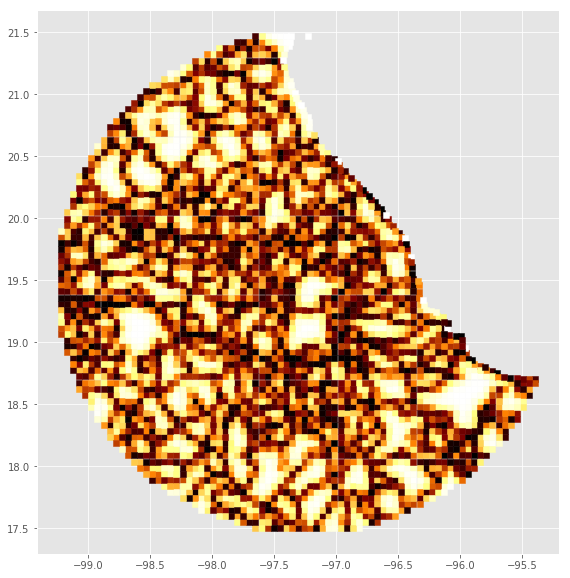

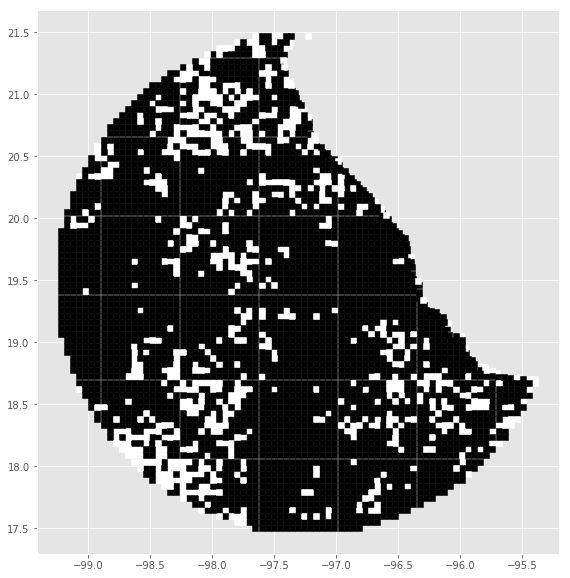

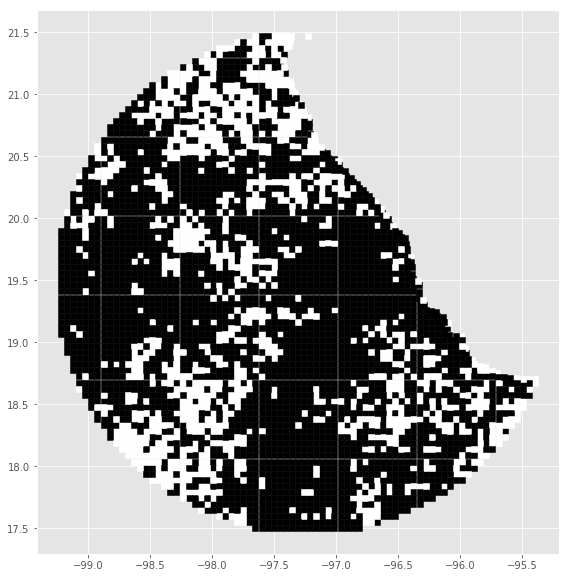

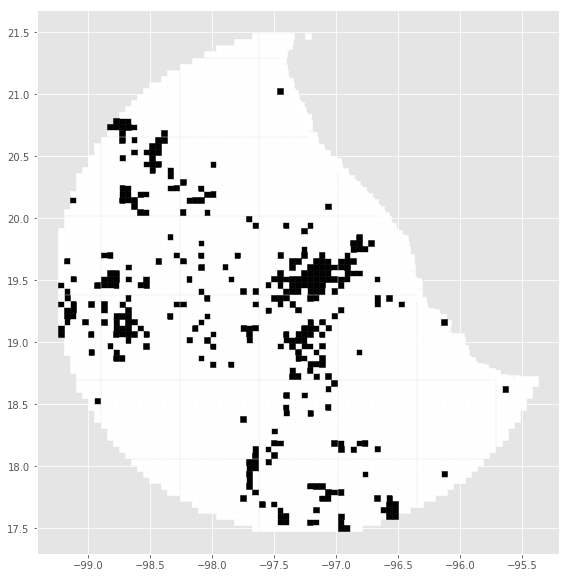

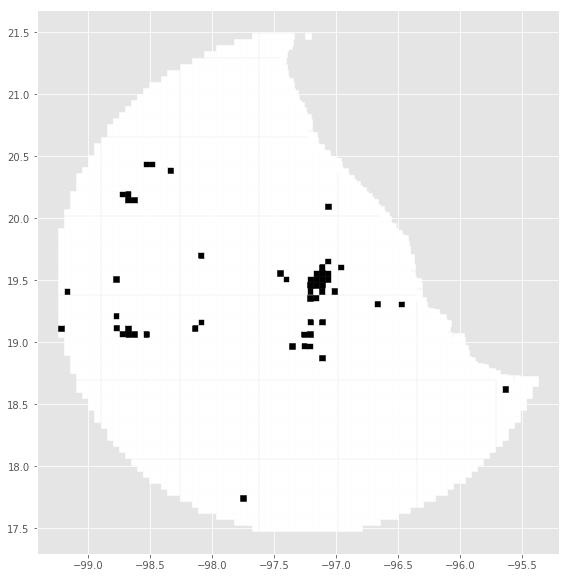

In [102]:
d.plot(column='Dist.to.road_m',marker='s',cmap=plt.cm.afmhot)
d.plot(column='LUCA',cmap=plt.cm.Greys,marker='s')
d.plot(column='Plantae',cmap=plt.cm.Greys,marker='s')
d.plot(column='Pinophyta',cmap=plt.cm.Greys,marker='s')
d.plot(column='Abies',cmap=plt.cm.Greys,marker='s')


## This is for getting  the neighbour structure

In [31]:
G = st.LatticeToNetworkx(cells[0])

In [32]:
lpositions = map(lambda n : (n.centroid.x, n.centroid.y), cells[0])
cellsids = map(lambda c : c.id, cells[0])
positions = dict(zip(cellsids,lpositions))


/opt/conda/envs/biospytial/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/conda/envs/biospytial/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/opt/conda/envs/biospytial/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/opt/conda/envs/biospytial/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot command

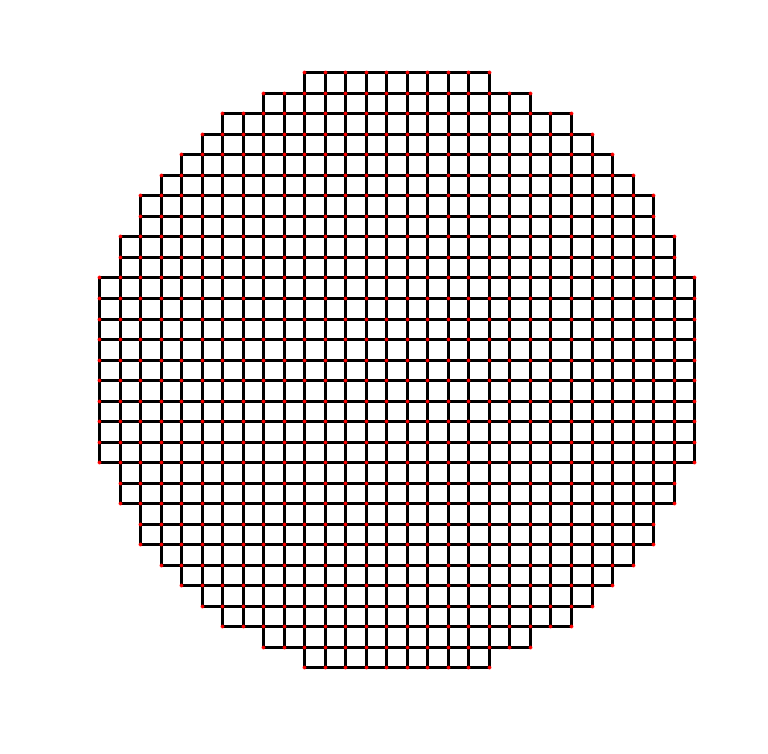

In [34]:
import networkx as nx
## Plot it
options = {
'node_size': 10,
'width': 3,}
nx.draw(G,positions,**options)

In [35]:
#Order the nodes according to their id value, just ot mke it expl
ordered_nodes_list = G.nodes()
#ordered_nodes_list.sort(key=lambda c : c.id)
ordered_nodes_list.sort()
M = nx.adjacency_matrix(G,nodelist=ordered_nodes_list)

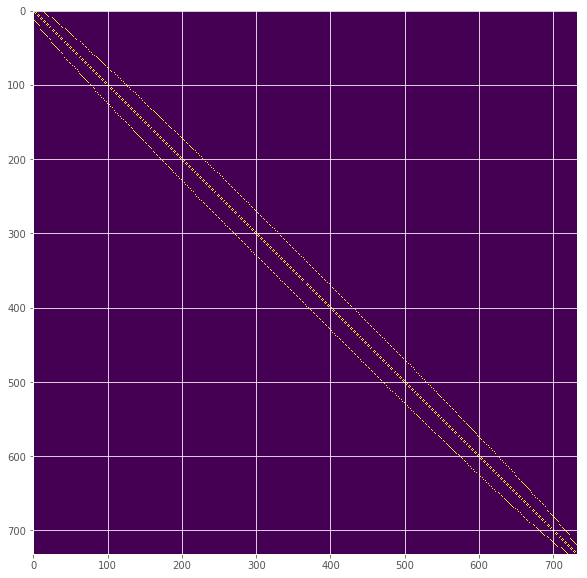

In [36]:
plt.imshow(M.toarray())

## Save it to posterity

In [103]:
## Let's save it in Redis
import redis
import pickle
conn = redis.StrictRedis(host='redis',password='biospytial.')

In [104]:
#tag = 't-guerrero-p4'
tag = 't-puebla-p9-abies-pinophyta'
#tag = 't-puebla-p3-abies-pinophyta'
#tag = 't-puebla-p4-abies-pinophyta'
#tag = 't-puebla-p2-abies-pinophyta'
conn.set(tag,pickle.dumps(d))

True

In [105]:
#d.to_csv("/outputs/training_data_sample_puebla_p4_abies_pinophyta.csv",encoding='utf8')
d.to_csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv",encoding='utf8')
#d.to_csv("/outputs/training_data_sample_puebla_p3_abies_pinophyta.csv",encoding='utf8')

In [106]:
d.shape

(4061, 24)

### Save the Adjancency matrix, BE CAREFULL ORDER FIRST!!


In [41]:
#mat_filename = "/outputs/training_data_sample_puebla_p4_abies_pinophyta_adjmat.npy"
#mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
mat_filename = "/outputs/training_data_sample_puebla_p3_abies_pinophyta_adjmat.npy"
np.save(mat_filename,M.toarray())

In [42]:
# Experimental, pickle network
#tag = 't-puebla-p9-abies-pinophyta-graph'
tag = 't-puebla-p3-abies-pinophyta-graph'
conn.set(tag,pickle.dumps(G))

True

In [ ]:
Load it R apply the CAR model.